In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data filtering

In [2]:
super_set = pd.read_csv("clustering_data.csv", low_memory=False)
super_set = super_set.dropna()

**Collecting the data of my homestate (Andhra Pradesh)**

In [3]:
andhra_df = super_set[super_set['StateName'] == 'ANDHRA PRADESH']
andhra_df.loc[:, "Latitude"] = pd.to_numeric(andhra_df["Latitude"], errors="coerce")
andhra_df.loc[:, "Longitude"] = pd.to_numeric(andhra_df["Longitude"], errors="coerce")
andhra_df = andhra_df.dropna(subset=["Latitude", "Longitude"])

# Data visualization

In [4]:
# extracting the latitudes and longitudes
lats_str = list(andhra_df.Latitude.to_numpy())
lats = [float(num) for num in lats_str] # converting the data from str ---> floats

longit_str = list(andhra_df.Longitude.to_numpy())
longit = [float(num) for num in longit_str] # converting the data from str ---> floats

# combining them into a single list 
coords = list(zip(lats,longit))
coords = np.array(coords)

**Test to see if there are anu NaN values**

In [5]:
print(np.any(coords))
print(np.any(lats))
print(np.any(longit))

True
True
True


**Plotting the gathered coordinates on a map, using `folium`**

In [6]:
# creating the figure using scatter_map
fig = px.scatter_map(
    andhra_df,
    lat="Latitude",
    lon="Longitude",
    zoom=6,
    center={"lat": andhra_df["Latitude"].mean(), "lon": andhra_df["Longitude"].mean()},
    height=600,
    width=800,
    title="Plot of Coordinates in Andhra Pradesh"
)
# setting the background as open-street-map, which gives the look of google maps
fig.update_layout(mapbox_style="open-street-map")
fig.show()

# Clustering analysis

 **Utility Functions**


In [7]:
# Function to compute Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b, axis=1)

**k-means function**

In [8]:

# Randomly initialize centroids by picking k random points
def kmeans(k):

    # generating the random initial centroids from the given dataset, to make it easier to converge 
    np.random.seed(0)

    initial_indices = np.random.choice(len(coords), k, replace=False)

    # assigning the centroids 
    centroids = coords[initial_indices]

    
    max_iters = 100
    for _ in range(max_iters):
        # labelling the coordinates with clusters
        distances = np.array([euclidean_distance(coords, c) for c in centroids])
        labels = np.argmin(distances, axis=0)

        # updating the centroids 
        new_centroids = np.array([coords[labels == i].mean(axis=0) for i in range(k)])

        # breaks the loop, if the centroids won't change
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    # adding these labels to the dataframe, which makes it easily accessible
    andhra_df["Cluster"] = labels
    # returns the labels and centroids to calculate centroids.
    return labels, centroids


**Function to plot the coordinates on map**

In [9]:
def plot_map(df):

    df['Cluster'] = df['Cluster'].astype(str)

    fig = px.scatter_map(
        df,
        lat="Latitude",
        lon="Longitude",
        color="Cluster",            
        zoom=6,
        height=600,
        width=800,
        title="K-Means Clusters on Andhra Pradesh Map",
    )
    # to view in on street 

    fig.update_layout(mapbox_style="open-street-map")  
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

**Davies bouldin Index** :

The Davies–Bouldin Index (DBI) is an internal evaluation metric for clustering algorithms like k-means. It helps assess how well-separated and compact the clusters are — and lower DBI values indicate better clustering.

For each cluster $ i $, the DBI compares:

- **Intra-cluster similarity**: How compact the cluster is (how close points are to the centroid).
- **Inter-cluster dissimilarity**: How far apart this cluster is from every other cluster.

Then, for every cluster $ i $, it finds the **worst-case similarity (most overlapping one)** with any other cluster $ j $:

$$
\text{DB}_i = \max_{j \neq i} \left( \frac{S_i + S_j}{M_{ij}} \right)
$$

Where:

- $S_i$ : average distance of points in cluster \( i \) to its centroid (intra-cluster scatter)  
- $M_{ij}$ : distance between centroids of cluster \( i \) and \( j \)

The **Davies–Bouldin Index** is the average over all clusters:

$$
\text{DBI} = \frac{1}{k} \sum_{i=1}^{k} \text{DB}_i
$$

In [10]:
def davies_bouldin_index(coords, labels):
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    centroids = []
    cluster_scatters = []

    # computing the centroid and Si
    for cluster in unique_labels:
        points = coords[labels == cluster]
        centroid = np.mean(points, axis=0)
        centroids.append(centroid)

        scatter = np.mean([np.linalg.norm(p - centroid) for p in points])
        cluster_scatters.append(scatter)

    centroids = np.array(centroids)
    cluster_scatters = np.array(cluster_scatters)

    # computing Rij and take max for each i
    dbi = 0
    for i in range(k):
        max_rij = -np.inf
        for j in range(k):
            if i == j:
                continue
            numerator = cluster_scatters[i] + cluster_scatters[j]
            denominator = np.linalg.norm(centroids[i] - centroids[j])
            rij = numerator / denominator if denominator != 0 else 0
            if rij > max_rij:
                max_rij = rij
        dbi += max_rij

    # returninf final DBI score
    return dbi / k

**Computing the WCSS**:

WCSS measures the total distance between each data point and the centroid of its assigned cluster. It's a measure of cluster compactness — lower values indicate that points are closer to their centroids, which is usually desirable.

Formula

For each cluster $k$, the WCSS is:

$$
\text{WCSS} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
$$

Where:

- $x_i$ : a data point in cluster $ C_k $  
- $ \mu_k $: the centroid of cluster $ k $  
- $|x_i - \mu_k\|^2 $: squared Euclidean distance from point to centroid

In [11]:
def compute_wcss(coords, labels, centroids):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = coords[labels == i]
        centroid = centroids[i]
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss


In [12]:
k_list = [num for num in range(5,20)]
k_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

**Computing the WCSS and Davies bouldin index and sppending them in a list**

In [13]:
davies_bouldin_list = []
wcss_list = []
for k in k_list:
    labels, centroids = kmeans(k)
    dbi_score = davies_bouldin_index(coords, labels)
    wcss_score = compute_wcss(coords,labels,centroids)
    davies_bouldin_list.append(dbi_score)
    wcss_list.append(wcss_score)


**Plotting the WCSS and Davies Bouldin Index**

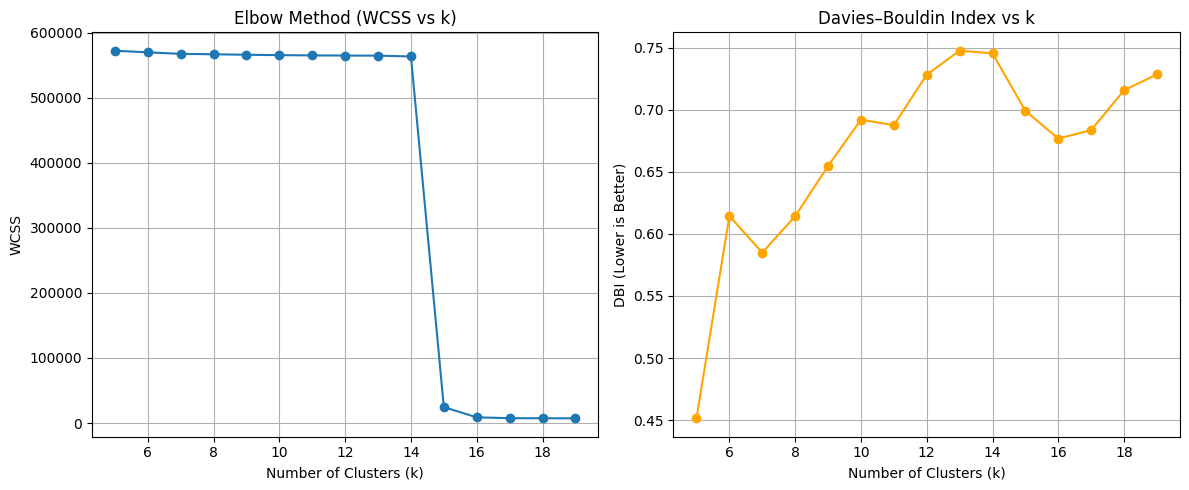

In [14]:
# Elbow Method (WCSS)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_list, wcss_list, marker='o')
plt.title('Elbow Method (WCSS vs k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)

# Davies–Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(k_list, davies_bouldin_list, marker='o', color='orange')
plt.title('Davies–Bouldin Index vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI (Lower is Better)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
kmeans(15) # plotting the map for optimal k 

plot_map(andhra_df)

# Inference

**Both the Elbow Method and Davies–Bouldin Index indicate that the optimal number of clusters for our dataset is 15. This value offers the best balance between minimizing intra-cluster variation and maximizing inter-cluster separation. The clustering results suggest meaningful and well-differentiated groups across Andhra Pradesh**